Author: Jose Caloca


Date: 13/10/2023

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from scipy.stats import ttest_ind, f_oneway, anderson_ksamp, ks_2samp
from utils.fairness_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
biased_model = True

In [3]:
if biased_model == True:
    path="./data/model_output_biased.csv"
else:
    path="./data/model_output_unbiased.csv"
    
df = pd.read_csv(path)
df.head()

,Sex,Prob_default,Predicted_default,Realised_default
0,male,0.070399,0,0
1,female,0.680952,1,1
2,male,0.066914,0,0
3,male,0.612083,1,0
4,male,0.470040,1,1


# Central tendency comparison: T-test & F-test

In [4]:
plot_pd_hist(df, {'decision_threshold' : 0.21930892990126283})

In [5]:
# separate the male and female groups
male = df[df['Sex'] == 'male']['Prob_default'].sort_values()
female = df[df['Sex'] == 'female']['Prob_default'].sort_values()

In [6]:
# perform t-test
t_stat, p_value = ttest_ind(male, female)
ttest_results = pd.DataFrame({'Statistic': t_stat, 'P-value': p_value}, index=['T-test'])

# perform f-test (one-way ANOVA)
f_stat, p_value = f_oneway(male, female)
anova_results = pd.DataFrame({'Statistic': f_stat, 'P-value': p_value}, index=['F-test'])

# combine the results into a single table
results_table = pd.concat([ttest_results, anova_results])

In [7]:
results_table

,Statistic,P-value
T-test,-7.912376,6.680117e-15
F-test,62.605702,6.680117e-15


# Distance between distributions

In [8]:
mean1 = np.mean(male)
mean2 = np.mean(female)
std1 = np.std(male, ddof=1)  # use ddof=1 for sample standard deviation
std2 = np.std(female, ddof=1)

# calculate Cohen's d
d = (mean2 - mean1) / np.sqrt((std1 ** 2 + std2 ** 2) / 2)

print("Cohen's d:", d)

Cohen's d: 0.5290338343043799


In [9]:
threshold_dict = {'Mean Male': mean1, 'Mean Female': mean2}
plot_pd_hist(df, threshold_dict=threshold_dict)

# Cumulative distribution comparison

In [10]:
male, cdf_male = cdf(male) 
female, cdf_female = cdf(female)

# Perform KS test
ks_stat, ks_pvalue = ks_2samp(male, female)

# Perform Anderson-Darling test
ad_stat, ad_crit_vals, ad_sig_level = anderson_ksamp([male, female])
ad_pvalue = 1 - ad_sig_level

# Create DataFrame with test results
results = pd.DataFrame({
    'Test': ['KS test', 'Anderson-Darling test'],
    'Statistic': [ks_stat, ad_stat],
    'P-value': [ks_pvalue, ad_pvalue]
})

In [11]:
results

,Test,Statistic,P-value
0,KS test,0.225339,5.150594e-10
1,Anderson-Darling test,37.480759,9.990000e-01


In [12]:
import plotly.graph_objs as go
import plotly.subplots as sp

# Create subplots
fig = sp.make_subplots(rows=1, cols=1)

# Plot CDF for Male
trace_male = go.Scatter(x=male, y=cdf_male, mode='lines', name='Male CDF', line=dict(color="#fea049"))

# Plot CDF for Female
trace_female = go.Scatter(x=female, y=cdf_female, mode='lines', name='Female CDF', line=dict(color="#4470ff"))

# Vertical dashed line for Max distance (ks_stat)
trace_ks_stat = go.Scatter(x=[0.40, 0.40], y=[0, 1], mode='lines', 
                           line=dict(color="green", dash="dash"), name='Max distance')

# Vertical dashed line for Decision cut-off
trace_decision_cutoff = go.Scatter(x=[0.21930892990126283, 0.21930892990126283], y=[0, 1], mode='lines', 
                                   line=dict(color="red", dash="dash"), name='Decision cut-off')

# Add traces to the subplot
fig.add_trace(trace_male)
fig.add_trace(trace_female)
fig.add_trace(trace_ks_stat)
fig.add_trace(trace_decision_cutoff)

# Update layout
fig.update_layout(
    title="Kolmogorov-Smirnov Test",
    xaxis_title="Scores",
    yaxis_title="Probability",
    template="simple_white",
    width=1000,
    height=600,
)

# Show the plot
fig.show()


### Integral difference

In [13]:
np.trapz(y=cdf_male, x=male) - np.trapz(y=cdf_female, x=female)

0.06152421401342856

# Decile comparison in scores: PSI and Average Score Difference

In [14]:
df['Decile_rank'] = add_decile(df, 'Prob_default')
df['unique_key'] = range(0, len(df))
male_df =  df[df['Sex'] == 'male']
female_df =  df[df['Sex'] == 'female']

In [15]:
results_psi = PSI(male_df, female_df, 'Prob_default', 'unique_key')
results_psi

Prob_default_x                     unique_key_x    perc_x  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.050850  0.020553  0.070399           90  0.130435   
1                 0.086688  0.071585  0.105785           81  0.117391   
2                 0.127503  0.105911  0.150965           69  0.100000   
3                 0.182183  0.151137  0.210260           74  0.107246   
4                 0.235895  0.210293  0.263739           67  0.097101   
5                 0.300014  0.264347  0.332459           77  0.111594   
6                 0.367880  0.333942  0.403684           71  0.102899   
7                 0.443181  0.406951  0.486201           60  0.086957   
8                 0.537142  0.486346  0.604468           59  0.085507   
9                 0.683013  0.605468  0.796882           42  0.060870   

            Prob_default_y                     unique_key_y    perc_y  \
                      mean       min       max        count             
Decile_rank                                                             
0                 0.055919  0.037642  0.070627           10  0.032258   
1                 0.090520  0.070743  0.104912           19  0.061290   
2                 0.130830  0.106918  0.150927           31  0.100000   
3                 0.179171  0.156380  0.209798           26  0.083871   
4                 0.238227  0.217778  0.263402           33  0.106452   
5                 0.295713  0.266078  0.332635           23  0.074194   
6                 0.365518  0.335536  0.401759           29  0.093548   
7                 0.445904  0.405350  0.486202           40  0.129032   
8                 0.534391  0.486775  0.603898           41  0.132258   
9                 0.683147  0.608298  0.838233           58  0.187097   

                  PSI  
                       
Decile_rank            
0            0.137163  
1            0.036460  
2            0.000000  
3            0.005747  
4            0.000860  
5            0.015267  
6            0.000891  
7            0.016605  
8            0.020391  
9            0.141740

In [16]:
results_psi['PSI'].sum()

0.375122068619999

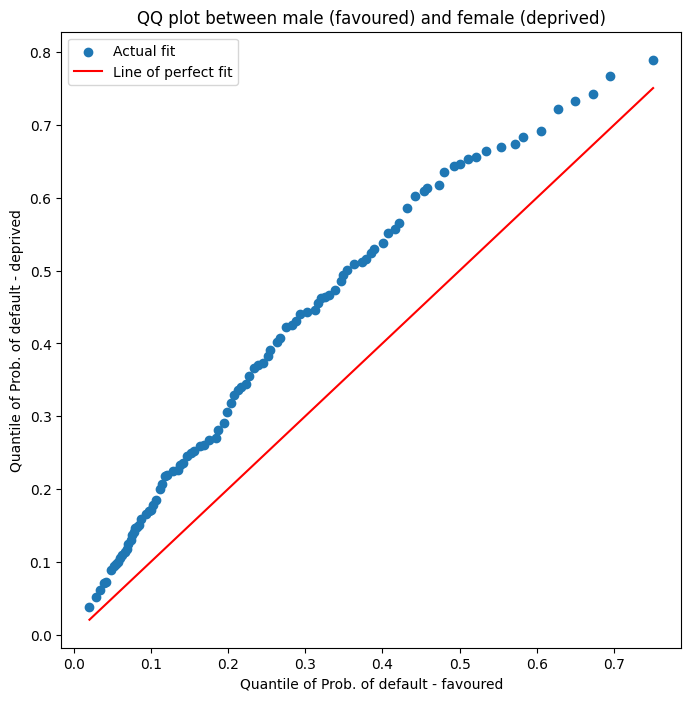

In [17]:
df_pct, linear_regression_result = score_percentile_comparison(
    df, 
    protected_variable = 'Sex', 
    score = 'Prob_default', 
    favoured_class='male', 
    deprived_class='female', 
    plot = True
)

In [18]:
df_pct

,q_deprived,q_favoured,difference
0,0.037642,0.020553,-0.017089
1,0.051439,0.029600,-0.021840
2,0.062006,0.034487,-0.027519
3,0.070659,0.039007,-0.031651
4,0.071926,0.042031,-0.029895
...,...,...,...
95,0.722126,0.627579,-0.094547
96,0.732651,0.649993,-0.082658
97,0.742023,0.672789,-0.069234
98,0.767407,0.694522,-0.072885


In [19]:
linear_regression_result

,slope,intercept,p_value
0,1.117082,0.072504,2.366424e-80


Interpretation: On average, the percentage difference in the percentile scores of the probability of default between the favoured and deprived group is 11.7%

In [20]:
# df_pct.to_excel("./data/pct_score_difference.xlsx", index=False)